In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
# Define company name and date ranges

In [4]:
COMPANY_IDENTIFIER = ['EMA','EMM','EMT','EMF']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000695-LIC,Retailer,EMBARC TAHOE LLC,True,Active,CA-04530,Retailer,465b4790-33c5-4228-adf3-5ee9f4edf62e,350aeac8-1a9b-4c7e-b62d-a439bcc4b7fb
1,CA,C10-0000774-LIC,Retailer,alameda patients group llc,True,Active,CA-05437,Retailer,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,8e104bcf-e0f2-46bb-ac63-14482463074f
2,CA,C10-0000786-LIC,Retailer,Embarc Martinez LLC,True,Active,CA-04530,Retailer,e4947919-767e-4a36-828f-ec8c03469591,db4badd6-18b6-4cff-b4d6-62c4b5f4bf16
3,CA,C10-0000939-LIC,Retailer,Responsible And Compliant Retail Fairfield LLC,True,Active,CA-04530,Retailer,4633ceb1-7b64-48d1-93db-4b030bfb7c6a,4ee65532-edaa-412f-ae6e-e63a2682f9db


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C10-0000695-LIC', 'C10-0000939-LIC', 'C10-0000774-LIC',
       'C10-0000786-LIC'], dtype=object)

In [9]:
def check_company_license_download(license_numbers: List[str],download_summary_records: List[Dict[str,str]]) -> Dict[str,str]:
    license_number_to_download_summary_records = {}

    for license_number in license_numbers:
        license_number_to_download_summary_records[license_number] = list(filter(
            lambda download_summary_record: download_summary_record['license_number'] == license_number,
            download_summary_records
        ))

    bad_count = 0
    bad_history = defaultdict(list)
    for license_number, download_summary_records in license_number_to_download_summary_records.items():
        print(f'Verifying download summaries for license {license_number}...')
        print(f'Earliest download summary: {download_summary_records[-1]["date"]}')
        print(f'Latest download summary: {download_summary_records[0]["date"]}')
        for download_summary_record in download_summary_records:
            if download_summary_record['status'] != 'completed':
                bad_count += 1
                print(f'Found bad download summary for license {license_number} on date {download_summary_record["date"]}') 
                bad_history[license_number].append(download_summary_record['date'])            
        
        print('')
    if bad_count > 0:
        print(f'[FAILURE] Found a total of {bad_count} bad download summaries')
    else:
        print(f'[SUCCESS] All download summaries look good!')
    return bad_history



In [10]:
bad_download_history = check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000695-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-05-04

Verifying download summaries for license C10-0000939-LIC...
Earliest download summary: 2021-10-01
Latest download summary: 2022-05-04

Verifying download summaries for license C10-0000774-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-05-03

Verifying download summaries for license C10-0000786-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-05-03
Found bad download summary for license C10-0000786-LIC on date 2022-03-11
Found bad download summary for license C10-0000786-LIC on date 2022-03-10
Found bad download summary for license C10-0000786-LIC on date 2022-03-09

[FAILURE] Found a total of 3 bad download summaries


In [11]:
bad_download_history

defaultdict(list,
            {'C10-0000786-LIC': [datetime.date(2022, 3, 11),
              datetime.date(2022, 3, 10),
              datetime.date(2022, 3, 9)]})

## Choose license numbers

In [12]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC']

In [13]:
#license_numbers = ['C10-0000670-LIC']

In [14]:
# run this if only has 1 license, or only want 1 license CSC
#license_numbers = [license_numbers[0]]
#license_numbers

# License check

In [15]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000695-LIC,Retailer,EMBARC TAHOE LLC,True,Active,CA-04530,Retailer,465b4790-33c5-4228-adf3-5ee9f4edf62e,350aeac8-1a9b-4c7e-b62d-a439bcc4b7fb
1,CA,C10-0000774-LIC,Retailer,alameda patients group llc,True,Active,CA-05437,Retailer,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,8e104bcf-e0f2-46bb-ac63-14482463074f
2,CA,C10-0000786-LIC,Retailer,Embarc Martinez LLC,True,Active,CA-04530,Retailer,e4947919-767e-4a36-828f-ec8c03469591,db4badd6-18b6-4cff-b4d6-62c4b5f4bf16
3,CA,C10-0000939-LIC,Retailer,Responsible And Compliant Retail Fairfield LLC,True,Active,CA-04530,Retailer,4633ceb1-7b64-48d1-93db-4b030bfb7c6a,4ee65532-edaa-412f-ae6e-e63a2682f9db


In [16]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

In [17]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]


In [18]:
retial_license_check_df

,license_number,license_category,is_current,license_status,us_state,license_check
0,C10-0000695-LIC,Retailer,True,Active,CA,YES
1,C10-0000774-LIC,Retailer,True,Active,CA,YES
2,C10-0000786-LIC,Retailer,True,Active,CA,YES
3,C10-0000939-LIC,Retailer,True,Active,CA,YES


## Pull data

In [19]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [20]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C10-0000774-LIC', 'C10-0000695-LIC', 'C10-0000786-LIC',
       'C10-0000939-LIC'], dtype=object)

In [21]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000695-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC',
       'C10-0000774-LIC'], dtype=object)

In [22]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000695-LIC',
       'C10-0000939-LIC'], dtype=object)

## Unknown transfer packages

In [23]:
def check_unknown_transfer_packages(unknown_transfer_df: pd.DataFrame) -> int:
    unknown_package_count = unknown_transfer_df.shape[0]
    if unknown_package_count > 0:
        print(f'[FAILURE] Found a total of {unknown_package_count} unknown transfer packages')
    else:
        print(f'[SUCCESS] No unknown transfer packages!')
    return unknown_package_count

In [24]:
unknown_package_count = check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[FAILURE] Found a total of 42 unknown transfer packages


42

## Receiver wholesale price coverage

In [25]:
def check_receiver_wholesale_price_coverage(incoming_transfer_df: pd.DataFrame) -> float:
    rwp_exists_count = incoming_transfer_df[incoming_transfer_df['receiver_wholesale_price'].notnull()].shape[0]
    total_count = incoming_transfer_df.shape[0]
    rwp_coverage = round(rwp_exists_count / total_count, 2) * 100
    print(f'{rwp_coverage}% of incoming transfer packages have receiver wholesale price')
    return rwp_coverage

In [26]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(24901, 32)

In [27]:
company_incoming_transfer_packages_dataframe.shape

(25778, 32)

In [28]:
rwp_coverage = check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


97.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [29]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [30]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [31]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000695-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC',
       'C10-0000774-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [32]:
def check_incoming_transfer_package_coverage(incoming_transfer_df: pd.DataFrame,sales_df: pd.DataFrame) -> Tuple[List,pd.DataFrame]:
    package_transfer_sales_merged = pd.merge(sales_df,incoming_transfer_df,left_on='tx_package_id', right_on='package_id', how='left')
    package_transfer_sales_merged_missed = package_transfer_sales_merged[package_transfer_sales_merged['package_id'].isnull()]
    count_trxn_missed = package_transfer_sales_merged_missed.shape[0]
    count_total_trxn = sales_df.shape[0]
    missed_ratio = count_trxn_missed/ count_total_trxn
    print(f'# transactions missing incoming transfer package: {count_trxn_missed} ({count_trxn_missed / count_total_trxn * 100}%)')
    print(f'# transactions total: {count_total_trxn}')
    return missed_ratio,package_transfer_sales_merged_missed

In [33]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 828 (0.15234086083625564%)
# transactions total: 543518


In [34]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2022-04    610
2022-05     89
dtype: int64

## Receipts missing metrc_sales_transactions

In [35]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [36]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 252798


In [37]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

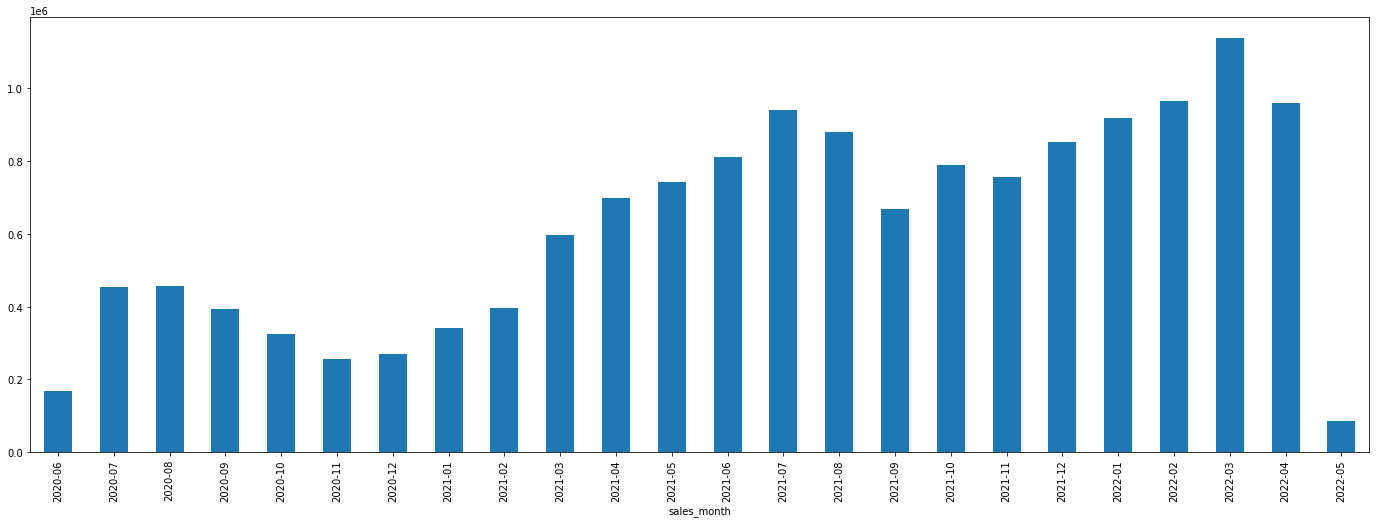

In [38]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

In [39]:
if COMPANY_IDENTIFIER == ['EMA','EMM','EMT','EMF']:
    #incoming transfer
    company_incoming_transfer_packages_dataframe_ema = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_incoming_transfer_packages_dataframe_emm = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_incoming_transfer_packages_dataframe_emt = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    company_incoming_transfer_packages_dataframe_emf = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000939-LIC']
    #sales & receipt
    deduped_sales_receipts_with_transactions_dataframe_ema = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000774-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emm = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000786-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emt = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000695-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emf = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000939-LIC']
    #inventory
    company_inventory_packages_dataframe_ema = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_inventory_packages_dataframe_emm = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_inventory_packages_dataframe_emt = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    company_inventory_packages_dataframe_emf = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000939-LIC']
    

# Vendor churn

In [40]:
WINDOW = 4
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-04-01'
VC_MONTH_LIST = ['2021-12-01','2022-01-01','2022-02-01','2022-03-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [41]:
def calculate_vendor_churn(incoming_transfer_df,license_list,vc_windown,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop(['__place_holder', 'shipper_facility_name'], axis=1)
        )
    ).reset_index().drop(['level_1'], axis=1)
    
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(vc_windown).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix
    


In [42]:
def calculate_vendor_churn_short(incoming_transfer_df,license_list,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop(['__place_holder', 'shipper_facility_name'], axis=1)
        )
    ).reset_index().drop(['level_1'], axis=1)
    
    
    # cast any purchase under $ 100 to be 0
    indices = vc_full[vc_full['shipper_wholesale_price'] < 100].index.to_list()
    vc_full.loc[indices,'shipper_wholesale_price'] = 0
    
    #rolling_4m_sum
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(4).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    
    #facility_monthly_running_total
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].rolling(window = 12).sum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    
    #monthly_running_total
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.iloc[: , -12:].sum(axis = 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[vc_month_list].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix
    


In [43]:
churn_ema,vc_matrix_ema = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_ema,['C10-0000774-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emm,vc_matrix_emm = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emm,['C10-0000786-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emt,vc_matrix_emt = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emt,['C10-0000695-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emf,vc_matrix_emf = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emf,['C10-0000939-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



In [44]:
churn_ema_short,vc_matrix_ema_short = calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_ema,['C10-0000774-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emm_short,vc_matrix_emm_short = calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_emm,['C10-0000786-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emt_short,vc_matrix_emt_short = calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_emt,['C10-0000695-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emf_short,vc_matrix_emf_short = calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_emf,['C10-0000939-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



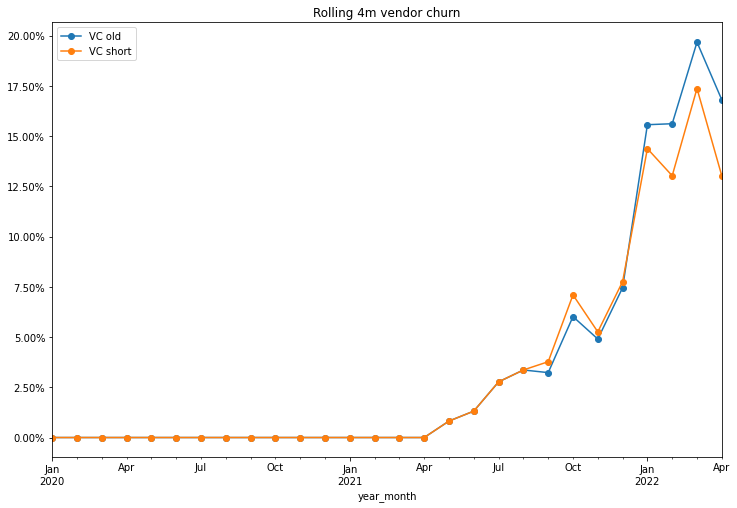

In [45]:
ax = churn_ema['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_ema_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [46]:
def check_per_unit_incoming(incoming_transfer_df: pd.DataFrame) -> Tuple[pd.DataFrame,pd.DataFrame]:
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    # by package ID
    per_unit_incoming_package_sort = incoming_transfer_df[['package_id','per_unit_incoming']].groupby(['package_id']).mean().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_package_top5 = per_unit_incoming_package_sort[0:5]
    print('printing per unit incoming by package ID summary ...')
    print(f'max per unit incoming: {per_unit_incoming_package_sort["per_unit_incoming"][0]}' + f' from package ID: {per_unit_incoming_package_sort["package_id"][0]}')
    print(f'min per unit incoming: {per_unit_incoming_package_sort.dropna()["per_unit_incoming"][-1:].values[0]}' + f' from package ID: {per_unit_incoming_package_sort.dropna()["package_id"][-1:].values[0]}')
    #print(per_unit_incoming_package_top5)
    print('')
    #by product name
    per_unit_incoming_product_sort = incoming_transfer_df[['product_name','per_unit_incoming']].groupby(['product_name']).max().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_product_top5 = per_unit_incoming_product_sort[0:5]
    return per_unit_incoming_package_sort,per_unit_incoming_product_sort


In [47]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: inf from package ID: 22088845
min per unit incoming: 0.00014705882352941178 from package ID: 17214454



In [48]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,22088845,inf
1,19579881,100.00
2,5668483,96.00
3,5668477,96.00
4,5668478,96.00
5,5668479,96.00
6,5668480,96.00
7,5668481,96.00
8,5668482,96.00
9,14295382,95.25


In [49]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
25409,20137432,0.000156
25410,20137429,0.000156
25411,20133351,0.000156
25412,20133358,0.000156
25413,17214454,0.000147


In [50]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,receiver_wholesale_price_1,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming
4097,INCOMING_FROM_VENDOR,C10-0000695-LIC,0003065290,2022-02-09,2022-02-10 21:02:38+00:00,Wholesale,C11-0000118-LIC,SECURE HAULING LLC,C10-0000695-LIC,EMBARC TAHOE LLC,Wholesale Manifest,Wholesale,22088845,1A40603000038C5000093515,transfer,1A4060300020919000000350,"r2.c1.21.01, r7.c2.21.01, r8.c2.21.01",Shipped,False,False,Vape Cartridge (weight - each),Friendly Farms - Horchata - 0.5g Cured Resin C...,passed,200.0,0.0,Each,NaN,NaN,None,NaN,0.5,Grams,inf


# COGS analysis

In [51]:
def cogs_analysis(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')

    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage','total_count']]

    #tax treatment
    df_summary_simp['revenue_after_tax'] = df_summary_simp['revenue'] * 1.15
    df_summary_simp['cogs_after_tax'] = df_summary_simp['cogs'] * 1.27
    df_summary_simp['margin_$_after_tax'] = df_summary_simp['revenue_after_tax'] - df_summary_simp['cogs_after_tax']
    df_summary_simp['margin_%_after_tax'] = df_summary_simp['margin_$_after_tax'] / df_summary_simp['revenue_after_tax']
    # past quarter pre tax
    df_summary_simp['gm_past_quarter'] = df_summary_simp[['margin_%']].rolling(3).mean().values
    df_summary_simp['gm_past_2quarters'] = df_summary_simp[['margin_%']].rolling(6).mean().values
    df_summary_simp['gm_past_3quarters'] = df_summary_simp[['margin_%']].rolling(9).mean().values
    df_summary_simp['sum_cogs_past_3months'] = df_summary_simp[['cogs']].rolling(3).sum().values
    # past quarter after tax
    df_summary_simp['gm_past_quarter_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(3).mean().values
    df_summary_simp['gm_past_2quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(6).mean().values
    df_summary_simp['gm_past_3quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(9).mean().values
    # revenue change
    #df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()

    if company_state == 'CA':
        df_summary_simp['gm_final'] = df_summary_simp['margin_%_after_tax']
        
        df_summary_simp['gm_past_quarter_final'] = df_summary_simp['gm_past_quarter_after_tax']
        df_summary_simp['gm_past_2quarters_final'] = df_summary_simp['gm_past_2quarters_after_tax']
        df_summary_simp['gm_past_3quarters_final'] = df_summary_simp['gm_past_3quarters_after_tax']
    else:
        df_summary_simp['gm_final'] = df_summary_simp['margin_%']
        df_summary_simp['gm_past_quarter_final'] = df_summary_simp['gm_past_quarter']
        df_summary_simp['gm_past_2quarters_final'] = df_summary_simp['gm_past_2quarters']
        df_summary_simp['gm_past_3quarters_final'] = df_summary_simp['gm_past_3quarters']
    df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change().values
    df_summary_simp.index = df_summary_simp.date 
    
    return df_summary_simp,df_cogs_average_product




In [52]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

# Revenue change vs state

In [53]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    else:
        return 10
    

### for CA

In [54]:
def calculate_quarterly_sum_gmv_ca(cogs_analysis_df):
    #2020
    sum_gmv_q1_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-01')&(cogs_analysis_df['date']<= '2020-03')]['revenue'].sum()
    sum_gmv_q2_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-04')&(cogs_analysis_df['date']<= '2020-06')]['revenue'].sum()
    sum_gmv_q3_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-07')&(cogs_analysis_df['date']<= '2020-09')]['revenue'].sum()
    sum_gmv_q4_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-10')&(cogs_analysis_df['date']<= '2020-12')]['revenue'].sum()
    #2021
    sum_gmv_q1_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-01')&(cogs_analysis_df['date']<= '2021-03')]['revenue'].sum()
    sum_gmv_q2_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-04')&(cogs_analysis_df['date']<= '2021-06')]['revenue'].sum()
    sum_gmv_q3_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-07')&(cogs_analysis_df['date']<= '2021-09')]['revenue'].sum()
    sum_gmv_q4_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-10')&(cogs_analysis_df['date']<= '2021-12')]['revenue'].sum()
    gmv_df = pd.DataFrame([sum_gmv_q1_2020,sum_gmv_q2_2020,sum_gmv_q3_2020,sum_gmv_q4_2020,\
                  sum_gmv_q1_2021,sum_gmv_q2_2021,sum_gmv_q3_2021,sum_gmv_q4_2021])
    gmv_df.columns = ['sum_gmv']
    gmv_df['sum_gmv_change'] = gmv_df['sum_gmv'].pct_change().values
    gmv_df['sum_gmv_change_ca'] = [numpy.nan,numpy.nan,numpy.nan,0.17,-0.05,0.02,-0.11,0]
    gmv_df['weight'] = [numpy.nan,numpy.nan,numpy.nan,0.04,0.28,0.52,0.76,1]
    gmv_df['variance'] = gmv_df['sum_gmv_change'] - gmv_df['sum_gmv_change_ca']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    gmv_df.index = ['2020Q1','2020Q2','2020Q3','2020Q4','2021Q1','2021Q2','2021Q3','2021Q4']
    #gmv_df = gmv_df.dropna()
    return gmv_df
    

### ema

In [57]:
df_inventory_ema = company_inventory_packages_dataframe_ema
df_sales_ema = deduped_sales_receipts_with_transactions_dataframe_ema

In [58]:
df_summary_simp_ema,_ = cogs_analysis(df_in,df_sales_ema,'monthly')



In [59]:
df_summary_simp_ema

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,20153.83,9313.385300,10840.444700,0.537885,1428.0,0.0,1428,1.000000,1428,23176.9045,11827.999331,11348.905169,0.489664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.489664,NaN,NaN,NaN,NaN
2021-02,2021-02,96470.73,38605.820283,57864.909717,0.599818,4541.0,0.0,4541,1.000000,4541,110941.3395,49029.391760,61911.947740,0.558060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.558060,NaN,NaN,NaN,3.786719
2021-03,2021-03,140476.60,56418.332147,84058.267853,0.598379,5307.0,0.0,5307,1.000000,5307,161548.0900,71651.281826,89896.808174,0.556471,0.578694,NaN,NaN,104337.537730,0.534732,NaN,NaN,0.556471,0.534732,NaN,NaN,0.456158
2021-04,2021-04,175902.90,70136.713090,105766.186910,0.601276,7640.0,0.0,7640,1.000000,7640,202288.3350,89073.625624,113214.709376,0.559670,0.599824,NaN,NaN,165160.865520,0.558067,NaN,NaN,0.559670,0.558067,NaN,NaN,0.252186
2021-05,2021-05,188438.49,71649.134894,116789.355106,0.619774,6973.0,0.0,6973,0.999283,6978,216704.2635,90994.401315,125709.862185,0.580099,0.606477,NaN,NaN,198204.180130,0.565413,NaN,NaN,0.580099,0.565413,NaN,NaN,0.071264
2021-06,2021-06,194103.29,74037.555970,120065.734030,0.618566,7636.0,0.0,7636,0.985290,7750,223218.7835,94027.696082,129191.087418,0.578764,0.613206,0.595950,NaN,215823.403953,0.572844,0.553788,NaN,0.578764,0.572844,0.553788,NaN,0.030062
2021-07,2021-07,224157.48,88062.298698,136095.181302,0.607141,9439.0,8.0,9431,0.998836,9450,257781.1020,111839.119347,145941.982653,0.566147,0.615161,0.607492,NaN,233748.989562,0.575003,0.566535,NaN,0.566147,0.575003,0.566535,NaN,0.154836
2021-08,2021-08,245512.11,96192.142364,149319.967636,0.608198,9149.0,322.0,8827,0.997819,9169,282338.9265,122164.020803,160174.905697,0.567314,0.611302,0.608889,NaN,258291.997033,0.570742,0.568078,NaN,0.567314,0.570742,0.568078,NaN,0.095266
2021-09,2021-09,219012.55,85973.800651,133038.749349,0.607448,8088.0,318.0,7770,0.986582,8198,251864.4325,109186.726827,142677.705673,0.566486,0.607596,0.610401,0.599832,270228.241714,0.566649,0.569747,0.558075,0.566486,0.566649,0.569747,0.558075,-0.107936


In [60]:
ema_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_ema)
ema_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.00,NaN,0.17,0.04,NaN,10,0.4
2021Q1,257101.16,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,558444.68,1.172082,0.02,0.52,1.152082,10,5.2
2021Q3,688682.14,0.233215,-0.11,0.76,0.343215,10,7.6
2021Q4,780310.51,0.133049,0.00,1.00,0.133049,10,10.0


In [61]:
round(ema_revenue_vs_state.dropna()['total'].sum(),2)

22.8

### emm

In [62]:
df_inventory_emm = company_inventory_packages_dataframe_emm
df_sales_emm = deduped_sales_receipts_with_transactions_dataframe_emm

In [63]:
df_summary_simp_emm,_ = cogs_analysis(df_in,df_sales_emm,'monthly')


In [64]:
df_summary_simp_emm

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03,2021-03,101169.45,47488.319560,53681.130440,0.530606,4474.0,0.0,4474,1.000000,4474,116344.8675,60310.165841,56034.701659,0.481626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.481626,NaN,NaN,NaN,NaN
2021-04,2021-04,258013.89,104777.059245,153236.830755,0.593909,9678.0,0.0,9678,1.000000,9678,296715.9735,133066.865242,163649.108258,0.551535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.551535,NaN,NaN,NaN,1.550314
2021-05,2021-05,282162.28,110435.511133,171726.768867,0.608610,9616.0,1.0,9615,0.996270,9652,324486.6220,140253.099139,184233.522861,0.567769,0.577708,NaN,NaN,262700.889939,0.533643,NaN,NaN,0.567769,0.533643,NaN,NaN,0.093593
2021-06,2021-06,292814.20,115306.966886,177507.233114,0.606211,9970.0,0.0,9970,0.994117,10029,336736.3300,146439.847945,190296.482055,0.565120,0.602910,NaN,NaN,330519.537265,0.561475,NaN,NaN,0.565120,0.561475,NaN,NaN,0.037751
2021-07,2021-07,326658.60,131105.311936,195553.288064,0.598647,12007.0,0.0,12007,0.996432,12050,375657.3900,166503.746158,209153.643842,0.556767,0.604489,NaN,NaN,356847.789955,0.563219,NaN,NaN,0.556767,0.563219,NaN,NaN,0.115583
2021-08,2021-08,344119.57,135400.150012,208719.419988,0.606532,11814.0,0.0,11814,0.996289,11858,395737.5055,171958.190515,223779.314985,0.565474,0.603797,0.590753,NaN,381812.428833,0.562454,0.548048,NaN,0.565474,0.562454,0.548048,NaN,0.053453
2021-09,2021-09,315679.80,129307.558306,186372.241694,0.590384,10768.0,0.0,10768,0.989433,10883,363031.7700,164220.599048,198811.170952,0.547641,0.598521,0.600716,NaN,395813.020253,0.556627,0.559051,NaN,0.547641,0.556627,0.559051,NaN,-0.082645
2021-10,2021-10,278104.29,111964.990222,166139.299778,0.597399,9749.0,0.0,9749,0.986541,9882,319819.9335,142195.537582,177624.395918,0.555389,0.598105,0.601297,NaN,376672.698540,0.556168,0.559693,NaN,0.555389,0.556168,0.559693,NaN,-0.119030
2021-11,2021-11,285601.18,112748.547427,172852.632573,0.605224,9356.0,0.0,9356,0.977026,9576,328441.3570,143190.655232,185250.701768,0.564030,0.597669,0.600733,0.593058,354021.095955,0.555687,0.559070,0.550595,0.564030,0.555687,0.559070,0.550595,0.026957


In [65]:
emm_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emm)
emm_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.00,NaN,0.17,0.04,NaN,10,0.4
2021Q1,101169.45,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,832990.37,7.233616,0.02,0.52,7.213616,10,5.2
2021Q3,986457.97,0.184237,-0.11,0.76,0.294237,10,7.6
2021Q4,887419.14,-0.100398,0.00,1.00,-0.100398,-5,-5.0


In [66]:
round(emm_revenue_vs_state.dropna()['total'].sum(),2)

7.8

### emt

In [67]:
df_inventory_emt = company_inventory_packages_dataframe_emt
df_sales_emt = deduped_sales_receipts_with_transactions_dataframe_emt

In [68]:
df_summary_simp_emt,_ = cogs_analysis(df_in,df_sales_emt,'monthly')


In [69]:
df_summary_simp_emt

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06,2020-06,168464.30,61034.192262,107430.107738,0.637703,5751.0,0.0,5751,1.000000,5751,193733.9450,77513.424173,116220.520827,0.599898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.599898,NaN,NaN,NaN,NaN
2020-07,2020-07,454664.49,173447.195669,281217.294331,0.618516,13969.0,0.0,13969,1.000000,13969,522864.1635,220277.938500,302586.225000,0.578709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.578709,NaN,NaN,NaN,1.698877
2020-08,2020-08,456226.13,167489.602869,288736.527131,0.632880,14171.0,0.0,14171,1.000000,14171,524660.0495,212711.795644,311948.253856,0.594572,0.629700,NaN,NaN,401970.990801,0.591060,NaN,NaN,0.594572,0.591060,NaN,NaN,0.003435
2020-09,2020-09,393929.64,146209.738615,247719.901385,0.628843,12322.0,0.0,12322,1.000000,12322,453019.0860,185686.368041,267332.717959,0.590114,0.626746,NaN,NaN,487146.537154,0.587798,NaN,NaN,0.590114,0.587798,NaN,NaN,-0.136547
2020-10,2020-10,325595.48,124824.219498,200771.260502,0.616628,11045.0,0.0,11045,1.000000,11045,374434.8020,158526.758763,215908.043237,0.576624,0.626117,NaN,NaN,438523.560983,0.587103,NaN,NaN,0.576624,0.587103,NaN,NaN,-0.173468
2020-11,2020-11,255188.40,97070.861693,158117.538307,0.619611,7956.0,0.0,7956,1.000000,7956,293466.6600,123279.994350,170186.665650,0.579918,0.621694,0.625697,NaN,368104.819806,0.582219,0.586639,NaN,0.579918,0.582219,0.586639,NaN,-0.216241
2020-12,2020-12,270067.64,102723.247042,167344.392958,0.619639,8397.0,4.0,8393,0.990096,8481,310577.7860,130458.523743,180119.262257,0.579949,0.618626,0.622686,NaN,324618.328233,0.578830,0.583314,NaN,0.579949,0.578830,0.583314,NaN,0.058307
2021-01,2021-01,320052.85,114302.292478,205750.557522,0.642864,10445.0,26.0,10419,0.991645,10533,368060.7775,145163.911447,222896.866053,0.605598,0.627371,0.626744,NaN,314096.401213,0.588488,0.587796,NaN,0.605598,0.588488,0.587796,NaN,0.185084
2021-02,2021-02,298615.28,112772.246149,185843.033851,0.622349,10785.0,0.0,10785,0.999629,10789,343407.5720,143220.752609,200186.819391,0.582942,0.628284,0.624989,0.626559,329797.785669,0.589496,0.585857,0.587592,0.582942,0.589496,0.585857,0.587592,-0.066981


In [70]:
emt_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emt)
emt_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,168464.30,NaN,NaN,NaN,NaN,10,NaN
2020Q3,1304820.26,6.745381,NaN,NaN,NaN,10,NaN
2020Q4,850851.52,-0.347917,0.17,0.04,-0.517917,-5,-0.2
2021Q1,974143.51,0.144904,-0.05,0.28,0.194904,10,2.8
2021Q2,862586.35,-0.114518,0.02,0.52,-0.134518,-5,-2.6
2021Q3,812894.33,-0.057608,-0.11,0.76,0.052392,10,7.6
2021Q4,730129.66,-0.101815,0.00,1.00,-0.101815,-5,-5.0


In [71]:
round(emt_revenue_vs_state.dropna()['total'].sum(),2)

2.6

### emf

In [72]:
df_inventory_emf = company_inventory_packages_dataframe_emf
df_sales_emf = deduped_sales_receipts_with_transactions_dataframe_emf

In [73]:
df_summary_simp_emf,_ = cogs_analysis(df_in,df_sales_emf,'monthly')


In [74]:
df_summary_simp_emf

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02,2022-02,97575.00,41102.654524,56472.345476,0.578758,4372,30,4342,0.992509,4405,112211.2500,52200.371245,60010.878755,0.534803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534803,NaN,NaN,NaN,NaN
2022-03,2022-03,198325.34,76239.651511,122085.688489,0.615583,7919,116,7803,0.986791,8025,228074.1410,96824.357419,131249.783581,0.575470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.575470,NaN,NaN,NaN,1.032543
2022-04,2022-04,213978.41,90659.404394,123319.005606,0.576315,9110,253,8857,0.991403,9189,246075.1715,115137.443580,130937.727920,0.532105,0.590219,NaN,NaN,208001.710429,0.547459,NaN,NaN,0.532105,0.547459,NaN,NaN,0.078926
2022-05,2022-05,20744.20,8761.713900,11982.486100,0.577631,766,23,743,1.000000,766,23855.8300,11127.376653,12728.453347,0.533557,0.589843,NaN,NaN,175660.769805,0.547044,NaN,NaN,0.533557,0.547044,NaN,NaN,-0.903055


In [75]:
emf_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emf)
emf_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.0,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.0,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.0,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.0,NaN,0.17,0.04,NaN,10,0.4
2021Q1,0.0,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,0.0,NaN,0.02,0.52,NaN,10,5.2
2021Q3,0.0,NaN,-0.11,0.76,NaN,10,7.6
2021Q4,0.0,NaN,0.00,1.00,NaN,10,10.0


In [76]:
round(emf_revenue_vs_state.dropna()['total'].sum(),2)

0.0

# Inventory

In [77]:
today = date.today()
today

datetime.date(2022, 5, 4)

In [78]:
COMPANY_IDENTIFIER

['EMA', 'EMM', 'EMT', 'EMF']

In [79]:
license_numbers

['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC']

In [80]:
def calculate_inventory_valuation(incoming_transfer_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    incoming_transfer_df_price = incoming_transfer_df[incoming_transfer_df['shipper_wholesale_price'].notnull()]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby(['package_id'])['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby(['product_name'])['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    #calculate inventory
    df_inventory_incoming = pd.merge(inventory_df, df_avg_incoming_price, left_on=['package_id'],right_on = ['package_id'], how='left')
    #left_on=['tx_product_name','tx_unit_of_measure'], right_on=['product_name','shipped_unit_of_measure'], how='left'
    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_product, left_on=['product_name'],right_on = ['product_name'], how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    
    inventory_product_value = df_inv_product_price['total_price'].sum()
    df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
    inventory_value = df_inventory_incoming['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_value
    total_inv_value_after_tax = (inventory_product_value + inventory_value) * 1.27
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
    inv_count_total = df_inventory_incoming['quantity'].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [total_inv_value_after_tax],
            [inv_total_incoming], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','value_after_tax','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

In [81]:
def calculate_msrp_based_inventory_valuation(incoming_transfer_df,sales_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
    sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")    
    # per unit msrp by package id
    df_msrp = sales_df[sales_df['tx_total_price'].notnull()]
    average_msrp_package_id = df_msrp.groupby('tx_package_id')['per_unit'].mean()
    df_avg_msrp_package_id = pd.Series(average_msrp_package_id).to_frame()
    df_avg_msrp_package_id = df_avg_msrp_package_id.reset_index()
    # per unit msrp by product name
    average_msrp_product = df_msrp.groupby('tx_product_name')['per_unit'].mean()
    df_avg_msrp_product = pd.Series(average_msrp_product).to_frame()
    df_avg_msrp_product = df_avg_msrp_product.reset_index()
    df_avg_msrp_product.rename(columns={'per_unit':'per_unit_product'}, inplace=True)
    
    #calculate inventory
    #merge with per unit msrp by package id
    df_inventory_package_id = pd.merge(inventory_df, df_avg_msrp_package_id, left_on=['package_id'],right_on = ['tx_package_id'], how='left')
    df_inventory_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    # merge with per unit msrp by product
    df_inv_null = df_inventory_package_id[df_inventory_package_id['per_unit'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_msrp_product, left_on=['product_name'],right_on = ['tx_product_name'], how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    inventory_product_value = df_inv_product_price['total_price'].sum()
    
    df_inventory_package_id['total_price'] = df_inventory_package_id['quantity'] * df_inventory_package_id['per_unit']
    inventory_package_id_value = df_inventory_package_id['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_package_id_value
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_package_id = df_inventory_package_id['per_unit'].count()
    inv_count_total = df_inventory_package_id['quantity'].count()
    inv_total_mapped = inv_count_product + inv_count_package_id
    inventory_coverage = inv_total_mapped / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [inv_total_mapped], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]
            ]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

In [82]:
df_inventory_license_ema_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_ema,df_inventory_ema,['C10-0000774-LIC'])
df_inventory_license_emm_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_emm,df_inventory_emm,['C10-0000786-LIC'])
df_inventory_license_emt_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_emt,df_inventory_emt,['C10-0000695-LIC'])
df_inventory_license_emf_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_emf,df_inventory_emf,['C10-0000939-LIC'])

In [83]:
df_inventory_license_ema_msrp

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-05-04,417086.712868,2325,2584,0.899768,[C10-0000774-LIC],ALAMEDA PATIENTS GROUP LLC


In [84]:
df_inventory_license_ema = calculate_inventory_valuation(df_in,df_inventory_ema,['C10-0000774-LIC'])
df_inventory_license_emm = calculate_inventory_valuation(df_in,df_inventory_emm,['C10-0000786-LIC'])
df_inventory_license_emt = calculate_inventory_valuation(df_in,df_inventory_emt,['C10-0000695-LIC'])
df_inventory_license_emf = calculate_inventory_valuation(df_in,df_inventory_emf,['C10-0000939-LIC'])

In [85]:
df_inventory_license_ema

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-05-04,200512.683106,254651.107545,2558,2584,0.989938,[C10-0000774-LIC],ALAMEDA PATIENTS GROUP LLC


# Create Template: updated

In [86]:
def get_gm_perc_thresholds(state):
    if state == 'CA':
        return [[0.41,0.47,0.56],[0.41,0.47,0.56],[0.42,0.48,0.56]]
    elif state == 'CO':
        return [[0.48,0.57,0.63],[0.48,0.57,0.63],[0.49,0.57,0.62]]
    elif state == 'MI':
        return [[0.43,0.48,0.54],[0.49,0.53,0.57],[0.54,0.56,0.58]]
    elif state == 'MA':
        return [[0.53,0.54,0.56],[0.54,0.54,0.56],[0.53,0.53,0.55]]
    else:
        return None
        

In [87]:
def get_gm_perc_scores(threshold,gm_3,gm_6,gm_9):
    # 3m score
    if gm_3 <= threshold[0][0]:
        score_3m = -2
    elif threshold[0][0] < gm_3 <= threshold[0][1]:
        score_3m = 0
    elif threshold[0][1] < gm_3 <= threshold[0][2]:
        score_3m = 5
    elif gm_3 > threshold[0][2]:
        score_3m = 5
    else:
        score_3m = 0
    # 6m score
    if gm_6 <= threshold[1][0]:
        score_6m = -2
    elif threshold[1][0] < gm_6 <= threshold[1][1]:
        score_6m = 0
    elif threshold[1][1] < gm_6 <= threshold[1][2]:
        score_6m = 5
    elif gm_6 > threshold[1][2]:
        score_6m = 5
    else:
        score_6m = 0
    # 9m score
    if gm_9 <= threshold[2][0]:
        score_9m = -2
    elif threshold[2][0] < gm_9 <= threshold[2][1]:
        score_9m = 0
    elif threshold[2][1] < gm_9 <= threshold[2][2]:
        score_9m = 5
    elif gm_9 > threshold[2][2]:
        score_9m = 5
    else:
        score_9m = 0
    return score_3m,score_6m,score_9m
    

In [88]:
current_month = '2022-03'

In [89]:
# create template file with after tax inventory valuation and also credit limit
def create_template_new(df_rev_vs_state,df_cogs_analysis,df_inventory_analysis,df_inventory_analysis_msrp,df_churn,df_license_check,license_list,state_):
    #legal name
    legal_name = df_inventory_analysis['legal_name'][0]
    # cogs coverage check
    metrc_cogs_coverage_current = df_cogs_analysis[df_cogs_analysis['coverage'] > 0]['coverage'].mean()
    metrc_cogs_coverage_current_reliable = metrc_cogs_coverage_current > 0.75
    print(metrc_cogs_coverage_current,metrc_cogs_coverage_current_reliable)
    
    # inventory coverage check
    metrc_inventory_coverage_current = df_inventory_analysis.coverage.values[0]
    metrc_inventory_coverage_current_reliable = metrc_inventory_coverage_current > 0.75
    print(metrc_inventory_coverage_current,metrc_inventory_coverage_current_reliable)
    
    # inventory TO
    inventory_to_current = df_cogs_analysis.loc[current_month]['sum_cogs_past_3months'] / df_inventory_analysis.value[0] * 4
    inventory_to_current_score = 0 if inventory_to_current < 6 else 10
    print(inventory_to_current,inventory_to_current_score)
    
    #inventory valuation
    inventory = df_inventory_analysis['value'][0]
    if state_ == 'CA':
        inventory_after_tax = df_inventory_analysis['value_after_tax'][0]
        sum_cogs_past_3months_after_tax = df_cogs_analysis['sum_cogs_past_3months'].loc[current_month] * 1.27
    else:
        inventory_after_tax = inventory
        sum_cogs_past_3months_after_tax = df_cogs_analysis['sum_cogs_past_3months'].loc[current_month] 
        
    #inventory valuation msrp based
    inventory_msrp = df_inventory_analysis_msrp['value'][0]
    
    # past 3m cogs with tax
    
    sum_cogs_past_3months = df_cogs_analysis['sum_cogs_past_3months'].loc[current_month] 
        
    # credit limit
    credit_limit = round(min(sum_cogs_past_3months_after_tax,inventory_after_tax),-4)
    
    # vendor churn score
    vendor_churn_current = df_churn.loc[current_month]['%_inactive'].values[0]
    vendor_churn_current_score = 0 if vendor_churn_current > 0.2 else 10
    print(vendor_churn_current,vendor_churn_current_score)
    # margin score
    if df_cogs_analysis.shape[0] < 10:
        gm_past_quarter = df_cogs_analysis.loc[current_month]['gm_final']
        gm_past_2quarters = df_cogs_analysis.shift(1).loc[current_month]['gm_final']
        gm_past_3quarters = df_cogs_analysis.shift(2).loc[current_month]['gm_final']
    else:
        # gm past 1,2,3 quarters (after tax if CA else pre tax)
        gm_past_quarter = df_cogs_analysis.loc[current_month]['gm_past_quarter_final']
        gm_past_2quarters = df_cogs_analysis.loc[current_month]['gm_past_2quarters_final']
        gm_past_3quarters = df_cogs_analysis.loc[current_month]['gm_past_3quarters_final']

    gm_past_quarter_score,gm_past_2quarters_score,gm_past_3quarters_score = get_gm_perc_scores(get_gm_perc_thresholds(state_),\
                                                                                              gm_past_quarter,\
                                                                                              gm_past_2quarters,\
                                                                                              gm_past_3quarters)
    # revenue vs state score
    revenue_state_score = min(round(df_rev_vs_state.dropna()['total'].sum(),2),10)
    
    # all templates
    template_data = pd.DataFrame([
              ['legal name',legal_name],
              ['date',current_month],
              ['license',license_list],
              ['license is current',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().is_current[0]],
              ['license is active',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_status[0]],
              ['license check',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_check[0]],
              ['metrc cogs coverage',metrc_cogs_coverage_current],
              ['metrc cogs coverage reliable ?',metrc_cogs_coverage_current_reliable],
              ['metrc inventory coverage',metrc_inventory_coverage_current],
              ['metrc inventory coverage reliable ?',metrc_inventory_coverage_current_reliable],
              ['inventory turnover',inventory_to_current],
              ['inventory turnover score',inventory_to_current_score],
              # gm
              ['GM past quarter',gm_past_quarter],
              ['GM score past quarter',gm_past_quarter_score],
              ['GM past 2 quarters',gm_past_2quarters],
              ['GM score past 2 quarters',gm_past_2quarters_score],
              ['GM past 3 quarters',gm_past_3quarters],
              ['GM score past 3 quarters',gm_past_3quarters_score],
              # vendor churn
              ['vendor churn',vendor_churn_current],
              ['vendor churn score',vendor_churn_current_score],
              # revenue trend vs state
              ['revenue vs state change score',revenue_state_score],
              # inventory valuation
              ['inventory valuation',round(inventory,2)],
              ['inventory valuation after tax (CA only)',round(inventory_after_tax,2)],
              # inventory valuation msrp based
              ['inventory valuation (msrp based)',round(inventory_msrp,2)],
              # sum past 3m cogs afte tax
              ['sum_cogs_past_3months',round(sum_cogs_past_3months,2)],
              ['sum_cogs_past_3months after tax (CA only)',round(sum_cogs_past_3months_after_tax,2)],

              # total score
              ['total score',inventory_to_current_score+gm_past_quarter_score+gm_past_2quarters_score+gm_past_3quarters_score+\
              vendor_churn_current_score+revenue_state_score],
              ['credit limit',credit_limit],
        
        
             ])
    return template_data


In [92]:
tempalte_ema = create_template_new(ema_revenue_vs_state,df_summary_simp_ema,df_inventory_license_ema,df_inventory_license_ema_msrp,churn_ema_short,retial_license_check_df,['C10-0000774-LIC'],\
                               company_state)
tempalte_ema



0.9840092627342796 True
0.989938080495356 True
5.907727456809114 0
0.17369177102228464 10


,0,1
0,legal name,ALAMEDA PATIENTS GROUP LLC
1,date,2022-03
2,license,[C10-0000774-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.984009
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.989938
9,metrc inventory coverage reliable ?,True


In [93]:
tempalte_emm = create_template_new(emm_revenue_vs_state,df_summary_simp_emm,df_inventory_license_emm,df_inventory_license_emm_msrp,churn_emm_short,retial_license_check_df,['C10-0000786-LIC'],\
                                   company_state)
tempalte_emm



0.9739341514233973 True
0.9924545051043053 True
6.815823433294121 10
0.18383819538242754 10


,0,1
0,legal name,EMBARC MARTINEZ LLC
1,date,2022-03
2,license,[C10-0000786-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.973934
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.992455
9,metrc inventory coverage reliable ?,True


In [94]:
tempalte_emt = create_template_new(emt_revenue_vs_state,df_summary_simp_emt,df_inventory_license_emt,df_inventory_license_emt_msrp,churn_emt_short,retial_license_check_df,['C10-0000695-LIC'],\
company_state)
tempalte_emt



0.9947748443106036 True
0.990521327014218 True
12.51502873535286 10
0.15164601334297634 10


,0,1
0,legal name,EMBARC TAHOE LLC
1,date,2022-03
2,license,[C10-0000695-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.994775
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.990521
9,metrc inventory coverage reliable ?,True


In [95]:
df_summary_simp_emf

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02,2022-02,97575.00,41102.654524,56472.345476,0.578758,4372,30,4342,0.992509,4405,112211.2500,52200.371245,60010.878755,0.534803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534803,NaN,NaN,NaN,NaN
2022-03,2022-03,198325.34,76239.651511,122085.688489,0.615583,7919,116,7803,0.986791,8025,228074.1410,96824.357419,131249.783581,0.575470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.575470,NaN,NaN,NaN,1.032543
2022-04,2022-04,213978.41,90659.404394,123319.005606,0.576315,9110,253,8857,0.991403,9189,246075.1715,115137.443580,130937.727920,0.532105,0.590219,NaN,NaN,208001.710429,0.547459,NaN,NaN,0.532105,0.547459,NaN,NaN,0.078926
2022-05,2022-05,20744.20,8761.713900,11982.486100,0.577631,766,23,743,1.000000,766,23855.8300,11127.376653,12728.453347,0.533557,0.589843,NaN,NaN,175660.769805,0.547044,NaN,NaN,0.533557,0.547044,NaN,NaN,-0.903055


In [96]:
tempalte_emf = create_template_new(emf_revenue_vs_state,df_summary_simp_emf,df_inventory_license_emf,df_inventory_license_emf_msrp,churn_emf_short,retial_license_check_df,['C10-0000939-LIC'],\
company_state)
tempalte_emf



0.992675638621618 True
0.992992992992993 True
nan 10
0.0 10


,0,1
0,legal name,Responsible and Compliant Retail Fairfield LLC
1,date,2022-03
2,license,[C10-0000939-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.992676
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.992993
9,metrc inventory coverage reliable ?,True


# Output data 

## embarc

In [ ]:
# ema
license_number = 'C10-0000774-LIC'
COMPANY_IDENTIFIER = 'EMA'
tempalte_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_ema_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_summary_simp_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_ema_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_ema_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
ema_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emm
license_number = 'C10-0000786-LIC'
COMPANY_IDENTIFIER = 'EMM'
tempalte_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emm_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_summary_simp_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emm_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emm_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emm_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emt
license_number = 'C10-0000695-LIC'
COMPANY_IDENTIFIER = 'EMT'
tempalte_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emt_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')

df_summary_simp_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emt_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emt_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emt_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emf
license_number = 'C10-0000939-LIC'
COMPANY_IDENTIFIER = 'EMF'
tempalte_emf.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emf.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emf_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')

df_summary_simp_emf.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emf_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emf_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emf_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')

